In [35]:
import numpy as np
import re
import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import spacy
nltk.download('punkt')
nltk.download('stopwords')
!python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')
ps = PorterStemmer()




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report


In [1]:
! git clone https://github.com/AshishJangra27/Fake-News-Classification

Cloning into 'Fake-News-Classification'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 40.48 MiB | 22.65 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!unzip /content/Fake-News-Classification/Fake.zip
!unzip /content/Fake-News-Classification/True.zip

Archive:  /content/Fake-News-Classification/Fake.zip
  inflating: Fake.csv                
  inflating: __MACOSX/._Fake.csv     
Archive:  /content/Fake-News-Classification/True.zip
  inflating: True.csv                
  inflating: __MACOSX/._True.csv     


In [23]:
import pandas as pd
true=pd.read_csv('/content/True.csv')
fake=pd.read_csv('/content/Fake.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


(23481, 4)

In [24]:
true['fake']=0
fake['fake']=1



In [25]:
df = pd.DataFrame()
df=pd.concat([true,fake])
df.head()

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [17]:
del true
del fake


In [26]:
df=df.drop(['text','subject','date'],axis=1)
df.head()

,title,fake
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


In [27]:
df=df.sample(frac=1)
df.head()

,title,fake
15864,British PM May appoints Julian Smith as chief ...,0
7417,"WATCH: Cartoon DESTROYS Trump, Shows Why He S...",1
14334,Zimbabwe's Mugabe in contact with ousted vice ...,0
16594,BREAKING! INVESTIGATION: Hillary Clinton Did N...,1
4882,Trump backs Republican healthcare plan: U.S. h...,0


In [30]:
df['title']

15864    British PM May appoints Julian Smith as chief ...
7417      WATCH: Cartoon DESTROYS Trump, Shows Why He S...
14334    Zimbabwe's Mugabe in contact with ousted vice ...
16594    BREAKING! INVESTIGATION: Hillary Clinton Did N...
4882     Trump backs Republican healthcare plan: U.S. h...
                               ...                        
4850      CNN Guest SMACKS DOWN Trump Supporter For Rac...
16754    HOW PRESIDENT EISENHOWER Solved The Illegal Im...
10061    “DIRTY JOBS” HOST MIKE ROWE Absolutely Destroy...
1890      Trump FURIOUS As Latest Obamacare Numbers Pro...
20294    SHOCK POLL In MUST WIN State Of FLORIDA: Hispa...
Name: title, Length: 44898, dtype: object

In [32]:
titles=np.array(df['title'])
titles

array(['British PM May appoints Julian Smith as chief whip: statement',
       ' WATCH: Cartoon DESTROYS Trump, Shows Why He Shouldn’t Be President',
       "Zimbabwe's Mugabe in contact with ousted vice president", ...,
       '“DIRTY JOBS” HOST MIKE ROWE Absolutely Destroys Guy Who Called Him A White Nationalist',
       ' Trump FURIOUS As Latest Obamacare Numbers Prove It’s Not Going Anywhere (IMAGES)',
       'SHOCK POLL In MUST WIN State Of FLORIDA: Hispanics Turn Backs On Crooked Hillary'],
      dtype=object)

In [37]:
corpus=[]
for i in tqdm.tqdm(range(len(titles))):
  news = re.sub(r'^a-zA-Z', '', titles[i])
  news = word_tokenize(news.lower())
  news = ' '.join([ps.stem(word) for word in news if not word in stopwords.words('english')])
  news = nlp(news).vector
  corpus.append(news)


100%|██████████| 44898/44898 [10:16<00:00, 72.81it/s]


In [40]:
x_train=corpus[:35000]
y_train=df['fake'][:35000]
x_test=corpus[35000:]
y_test=df['fake'][35000:]
classifier=LogisticRegression(random_state=1)
classifier.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [41]:
y_pred=classifier.predict(x_test)

In [43]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[4501,  217],
       [ 375, 4805]])

In [44]:
print('Accuracy is',accuracy_score(y_test,y_pred))

Accuracy is 0.940189937361083


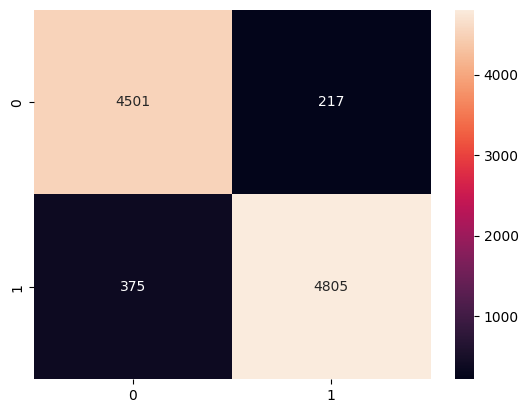

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')
plt.show()

In [49]:
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      4718
           1       0.96      0.93      0.94      5180

    accuracy                           0.94      9898
   macro avg       0.94      0.94      0.94      9898
weighted avg       0.94      0.94      0.94      9898

